In [134]:
# imports
import numpy as np
import pandas as pd
import re
import string
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import json
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import random
ps = PorterStemmer()
stop_words = set(stopwords.words('english')) 
stop_words.remove('not')
stop_words.add('facebook')

In [2]:
# opening the json file and getting the data
path=r"C:\Users\Hard Parikh\Desktop\facebook.txt"
file=open(path,encoding='utf-8')
data=json.load(file)

In [3]:
# seperating the questions and answers
questions=[]
answers=[]
for i in range(len(data['data'][0]['questions'])):
    questions.append(data['data'][0]['questions'][i]['input_text'])
    answers.append(data['data'][0]['answers'][i]['input_text'])

In [113]:
# functions required for cleaning the text
def lower(x):
    return x.lower()
def no_punct(x):
    return ' '.join([word for word in nltk.word_tokenize(x) if word not in string.punctuation])
def remove_sw(x):
    return ' '.join([word for word in nltk.word_tokenize(x) if word not in stop_words])
def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|]", "", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = " ".join(text.split())
    return text
def stem_words(x):
    return ' '.join([ps.stem(word) for word in nltk.word_tokenize(x)])
def no_repeat(sent):
    x=[]
    for i in sent.split():
        if(i not in x):
            x.append(i)
    sent=' '.join(x)
    return sent
questions[4]

'On facebook, When a Page likes my Page, does it affect my total fan count ?'

In [114]:
# cleaning the questions and creating the required outputs
cleaned_questions=[]
for i in range(len(questions)):
    cleaned_questions.append(no_repeat(stem_words(clean_text(remove_sw(no_punct(lower(questions[i])))))))
cleaned_outputs=[]
for i in cleaned_questions:
    cleaned_outputs.append('sostok '+i+' eostok')
cleaned_outputs[0]
new_cleaned_questions=[]
for i in range(len(cleaned_questions)):
    new_cleaned_questions.append((cleaned_questions[i],'sostok '+cleaned_questions[i]+' eostok'))
    for j in range(4):
        new_cleaned_questions.append((' '.join(random.sample(nltk.word_tokenize(cleaned_questions[i]),k=len(nltk.word_tokenize(cleaned_questions[i])))),'sostok '+cleaned_questions[i]+' eostok'))
X=[]
Y=[]
for i in range(len(new_cleaned_questions)):
    X.append(new_cleaned_questions[i][0])
    Y.append(new_cleaned_questions[i][1])
cleaned_questions=X
cleaned_outputs=Y

'page like affect total fan count'

In [116]:
# Tokenization of input and output
quest_tokenizer=Tokenizer()
quest_tokenizer.fit_on_texts(cleaned_questions)
seq_quest=quest_tokenizer.texts_to_sequences(cleaned_questions)
max_seq_len_quest=max([len(x) for x in seq_quest])
padded_quest=np.array(pad_sequences(seq_quest,maxlen=max_seq_len_quest,padding='post'))

out_tokenizer=Tokenizer()
out_tokenizer.fit_on_texts(cleaned_outputs)
seq_out=out_tokenizer.texts_to_sequences(cleaned_outputs)
max_seq_len_out=max([len(x) for x in seq_out])
padded_out=np.array(pad_sequences(seq_out,maxlen=max_seq_len_out,padding='post'))

print(padded_out.shape)
print(padded_quest.shape)

vocab_size_quest=len(quest_tokenizer.word_index)+1
vocab_size_out=len(out_tokenizer.word_index)+1

(200, 10)

In [118]:
# Encoder-Decoder model with Attention Mechanism
from keras import backend as K 
from keras.layers import Input,Embedding,LSTM
from Attention.layers.attention import AttentionLayer
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from Attention.layers.attention import AttentionLayer
K.clear_session()
latent_dim = 100
embedding_dim=100
max_text_len=max_seq_len_quest
encoder_inputs = Input(shape=(max_text_len,))
enc_emb =  Embedding(vocab_size_quest, embedding_dim,trainable=True)(encoder_inputs)
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(vocab_size_out, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_dense =  TimeDistributed(Dense(vocab_size_out, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 100)      11000       input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 10, 100), (N 80400       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [125]:
# training
x_tr=padded_quest
y_tr=padded_out
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1500,batch_size=128,verbose=2)

Epoch 1/1500
200/200 - 2s - loss: 4.7089 - acc: 0.1768
Epoch 2/1500
200/200 - 0s - loss: 4.6712 - acc: 0.5364
Epoch 3/1500
200/200 - 0s - loss: 4.6231 - acc: 0.5364
Epoch 4/1500
200/200 - 0s - loss: 4.5479 - acc: 0.5364
Epoch 5/1500
200/200 - 0s - loss: 4.4128 - acc: 0.5364
Epoch 6/1500
200/200 - 0s - loss: 4.1524 - acc: 0.5364
Epoch 7/1500
200/200 - 0s - loss: 3.6355 - acc: 0.5364
Epoch 8/1500
200/200 - 0s - loss: 2.8379 - acc: 0.5364
Epoch 9/1500
200/200 - 0s - loss: 2.4454 - acc: 0.5364
Epoch 10/1500
200/200 - 0s - loss: 2.5325 - acc: 0.5364
Epoch 11/1500
200/200 - 0s - loss: 2.4370 - acc: 0.5364
Epoch 12/1500
200/200 - 0s - loss: 2.3018 - acc: 0.5364
Epoch 13/1500
200/200 - 0s - loss: 2.2704 - acc: 0.5364
Epoch 14/1500
200/200 - 0s - loss: 2.2828 - acc: 0.5464
Epoch 15/1500
200/200 - 0s - loss: 2.2452 - acc: 0.5586
Epoch 16/1500
200/200 - 0s - loss: 2.1849 - acc: 0.5505
Epoch 17/1500
200/200 - 0s - loss: 2.1421 - acc: 0.5441
Epoch 18/1500
200/200 - 0s - loss: 2.1246 - acc: 0.5405
E

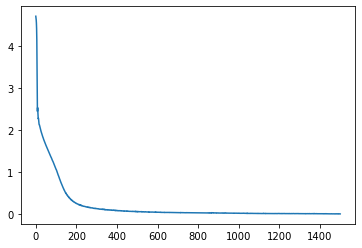

In [126]:
# loss graph plotting and saving the weights for later use
plt.plot(history.history['loss'])
plt.show()
model_json=model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
model.save_weights("arshitfacebook.h5")

In [127]:
# requirements for decoding
reverse_target_word_index=out_tokenizer.index_word
reverse_source_word_index=quest_tokenizer.index_word
target_word_index=out_tokenizer.word_index
reverse_target_word_index[0]='sostok'

In [128]:
# model for decoding
encoder=Model(encoder_inputs,[encoder_outputs,state_h,state_c])
decoder_state_h=Input(shape=(latent_dim,))
decoder_state_c=Input(shape=(latent_dim,))
decoder_hidden_state_input=Input(shape=(max_text_len,latent_dim))
dec_emb2=dec_emb_layer(decoder_inputs)
decoder_output2,state_h2,state_c2=decoder_lstm(dec_emb2,initial_state=[decoder_state_h,decoder_state_c])
attn_out_inf,attn_states_inf=attn_layer([decoder_hidden_state_input,decoder_output2])
decoder_inf_concat=Concatenate(axis=-1,name='concat')([decoder_output2,attn_out_inf])
decoder_output2=decoder_dense(decoder_inf_concat)
decoder=Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_h, decoder_state_c],[decoder_output2] + [state_h2, state_c2])

In [129]:
# functions required for decoding the result
def decode_sequence(input_seq):
    e_out,e_h,e_c=encoder.predict(input_seq)
    target_seq=np.zeros((1,1))
    target_seq[0,0]=target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_seq_len_out-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [131]:
# testing the result on training data
for i in range(len(x_tr)):
    print("Question:",seq2text(x_tr[i]))
    print("Predicted answer:",decode_sequence(x_tr[i].reshape(1,max_seq_len_quest)))
    print("\n")

Question: found 
Predicted answer:  found sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: found 
Predicted answer:  found sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: found 
Predicted answer:  found sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: found 
Predicted answer:  found sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: found 
Predicted answer:  found sostok sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: found year 
Predicted answer:  found year sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: year found 
Predicted answer:  found year sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: found year 
Predicted answer:  found year sostok sostok sostok sostok sostok sostok sostok sostok sostok


Question: year found 
Predicted answer:  found year sostok sostok sostok sostok

In [132]:
# chatbot(Cheese) function 
def chatBot():
    k=1
    print("Cheese:- Hi my name is Cheese. I am an AI chatbot and I can answer questions about the largest social networking company Facebook. ")
    while(k!=0):
        option=input("Cheese:-Would you like to ask a question or should I pick up a random one for you? ")
        if(option=='random' or option=='Random' or option=='R' or option=='r'):
            test_text=random.choice(questions)
        elif(option=='manual' or option=='Manual' or option=='M' or option=='m'):
            test_text=input("Enter you question here:-")
        else:
            print("Cheese:-You choose a wrong option. Please try again later.")
            k=0
            return 
        print("Question:-",test_text)
        test_text=stem_words(clean_text(remove_sw(no_punct(lower(test_text)))))
        test_text=no_repeat(test_text)
    #     print(test_text)
        test_text_padded=pad_sequences(quest_tokenizer.texts_to_sequences([test_text]),maxlen=max_seq_len_quest,padding='post')[0].reshape(1,max_seq_len_quest)
        encoder=Model(encoder_inputs,[encoder_outputs, state_h, state_c])
        en_pred=encoder.predict([x_tr,y_tr[:,:-1]])
        x=[]
        for i in range(len(en_pred[0])):
            x.append(en_pred[0][i].reshape(1000,1))
        np.array(x).shape
        x[0].shape
        test_text_padded
        pred_test=encoder.predict([test_text_padded,test_text_padded[:,:-1]])
        pred_test=pred_test[0].reshape(10,100)
        pred_test=pred_test.reshape(1000,1)
        x=np.array(x)
        errors=[]
        for i in range(len(x)):
            errors.append([(sum((x[i]-pred_test)**2))**(0.5),i])
        errors.sort()
        print('CLosest question:-',questions[int(errors[0][1]/5)])
        print("Answer:-",answers[int(errors[0][1]/5)])
        print()
        repeat=input("Cheese:-Enter 't' if you want to keep talking to me and 'q' if you want to exit.")
        if(repeat=='t'):
            k=1
        elif(repeat=='q'):
            print()
            print("Cheese:-Thank you for choosing me as your chatBot.")
            k=0
        else:
            print()
            print("Cheese:-You choose a wrong option. Please try again later.")
            return

In [135]:
# final result
chatBot()

Cheese:- Hi my name is Cheese. I am an AI chatbot and I can answer questions about the largest social networking company Facebook. 
Cheese:-Would you like to ask a question or should I pick up a random one for you? r
Question:- Facebook uses Artificial Intelligence for what ?
CLosest question:- Facebook uses Artificial Intelligence for what ?
Answer:- Facebook is putting artificial intelligence to use to identify porn, protect Mark Zuckerberg and connect to your brain waves.

Cheese:-Enter 't' if you want to keep talking to me and 'q' if you want to exit.t
Cheese:-Would you like to ask a question or should I pick up a random one for you? r
Question:- Ranking of Mark Zuckerberg in the Forbes List?
CLosest question:- Ranking of Mark Zuckerberg in the Forbes List?
Answer:- Mark Zuckerberg is ranked 6 in the Forbes List.

Cheese:-Enter 't' if you want to keep talking to me and 'q' if you want to exit.t
Cheese:-Would you like to ask a question or should I pick up a random one for you? m
Ent